In [1]:
# Imports
import torch
torch.cuda.empty_cache()

import hr_dv2.transform as tr
from hr_dv2.utils import *
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


PATCH_SIZE  = 14
FEAT_DIM = 384

In [2]:
from hr_dv2 import HighResDV2, torch_pca

net = HighResDV2("dinov2_vits14_reg", 4, pca_dim=128, dtype=torch.float16)
net.cuda()
net.eval()
pass

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


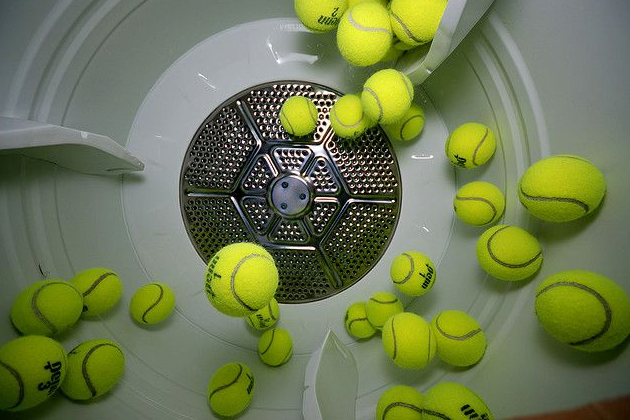

In [3]:
path = "data/balls.jpeg"
_img = Image.open(path)
_h, _w = _img.height, _img.width
t = tr.closest_crop(_h, _w, 14, True)
img_tensor, img = tr.load_image(path, t)
img_arr = np.array(img)
h, w, c = img_arr.shape


img_tensor.to(torch.float16)
img_tensor = img_tensor.cuda()
img

In [4]:
shift_dists = [i for i in range(1, 3)]
fwd_shift, inv_shift = tr.get_shift_transforms(shift_dists, 'Moore')
fwd_flip, inv_flip = tr.get_flip_transforms()
net.set_transforms(fwd_shift, inv_shift)

#_ = net.get_dv2_features(tensor.unsqueeze(0), 14)
attn = "o"
feats_attn_tensor = net.forward_sequential(img_tensor, attn_choice=attn)
print(feats_attn_tensor.shape)
if attn != "none":
    feats, attn = feats_attn_tensor[0, :-6, :, :], feats_attn_tensor[0, -6:, :, :]
else:
    feats = feats_attn_tensor[0]

torch.Size([1, 390, 420, 630])


In [5]:
pcaed = torch_pca(feats, 3, max_samples=50000)
pcaed = tr.to_numpy(pcaed)

In [6]:
rescaled = rescale_pca(pcaed)

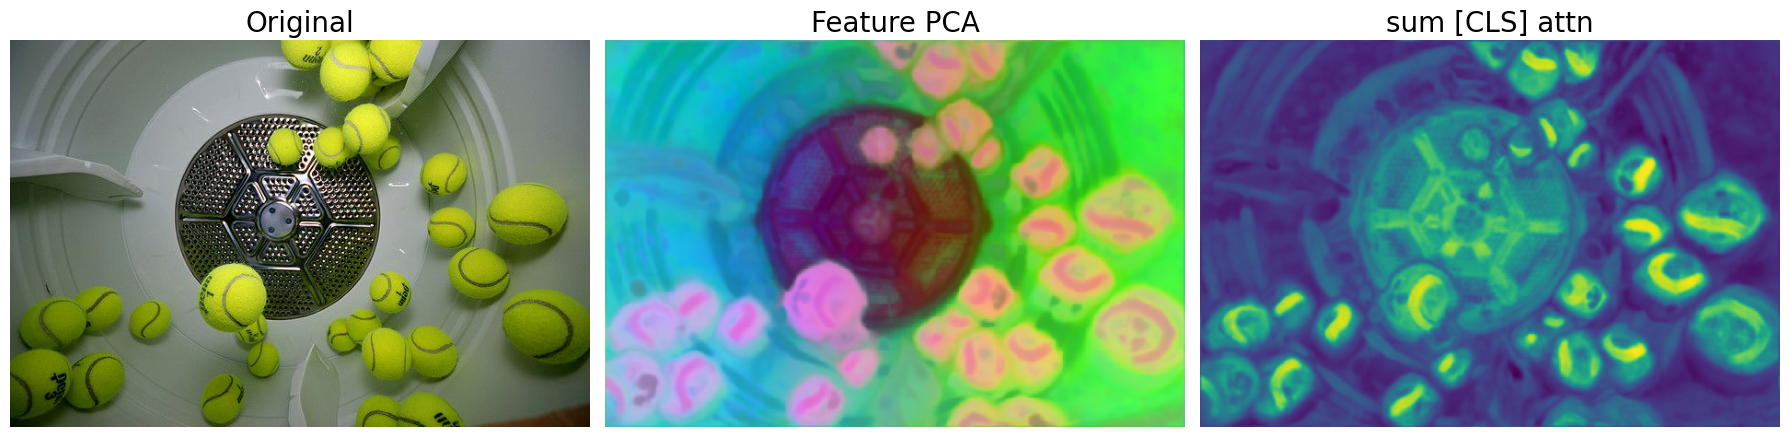

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(18, 8)

axs[0].imshow(img)
axs[1].imshow(rescaled.reshape(h, w, 3), interpolation='nearest')
axs[2].imshow(np.sum(tr.to_numpy(attn), axis=0))

titles = ["Original", "Feature PCA", "sum [CLS] attn"]
for i, ax in enumerate(axs):
    ax.set_axis_off()
    ax.set_title(titles[i], fontsize=20)
plt.tight_layout()